In [2]:
from matplotlib.dates import date2num, num2date
from matplotlib.colors import ListedColormap
from matplotlib import dates as mdates
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
from matplotlib import ticker

import seaborn as sns

from global_config import config
import pandas as pd
import numpy as np
import rpy2
import os

from datetime import date, timedelta


data_dir_mnps   = config.get_property('geo_dir')
data_dir        = config.get_property('data_dir')
fb_ppl_data     = config.get_property('covid_fb')
results_dir     = config.get_property('results_dir')
data_cases_path = os.path.join(fb_ppl_data, 'agglomerated', 'geometry')


In [3]:

# Defines lockdowns
no_lock_lab = "No Lockdown Imposed"
lock_lab    = "Lockdown Imposed"


lockdowns = []
lockdowns.append({"code": "A",
                  "start_date" : pd.to_datetime("2020-07-13"),
                  "end_date"   : pd.to_datetime("2020-07-23"),
                  "places":["chapinero",
                            "los_martires",
                            "san_cristobal",
                            "tunjuelito",
                            "rafel_uribe_uribe",
                            "ciudad_bolivar",
                            "santa_fe",
                            "usme"]})

lockdowns.append({"code": "B",
                  "start_date" : pd.to_datetime("2020-07-23"),
                  "end_date"   : pd.to_datetime("2020-08-06"),
                  "places":["bosa",
                            "antonio_narino",
                            "kennedy",
                            "puente_aranda",
                            "fontibon"]})

lockdowns.append({"code": "C",
                  "start_date" : pd.to_datetime("2020-07-31"),
                  "end_date"   : pd.to_datetime("2020-08-14"),
                  "places":["suba",
                            "engativa",
                            "barrios_unidos"]})

lockdowns.append({
                  "code": "D",
                  "start_date" : pd.to_datetime("2020-08-16"),
                  "end_date"   : pd.to_datetime("2020-08-27"),
                  "places":["usaquen",
                            "chapinero",
                            "santa_fe",
                            "candelaria",
                            "teusaquillo",
                           "puente_aranda",
                           "antonio_narino"]})


In [4]:
dict_correct = {'Los Martires': 'Los Mártires', 'Fontibon': 'Fontibón', 'Engativa': 'Engativá',
                            'San Cristobal': 'San Cristóbal', 'Usaquen': 'Usaquén',
                            'Ciudad Bolivar': 'Ciudad Bolívar', 'Candelaria': 'La Candelaria'}

# load Rt locality estimates
cases_df = pd.read_csv(os.path.join(data_cases_path, 'cases.csv'), parse_dates=["date_time"])


cases_df["poly_id"]  = cases_df["poly_id"].apply(lambda s:   s.replace("colombia_bogota_localidad_",""))

cases_df["poly_name"]  = cases_df["poly_id"].apply(lambda s:   ' '.join( [word.capitalize() for word in s.replace("colombia_bogota_localidad_","").split('_') ] ) )
cases_df["poly_name"]  = cases_df["poly_name"].replace( dict_correct )

cases_bog_df = cases_df.groupby(['poly_id', 'poly_name', 'date_time']).sum()[["num_cases", "num_diseased", "num_infected_in_icu"]]
cases_bog_df = cases_bog_df.unstack([0,1]).resample('1D').sum().stack().stack().reset_index().rename(columns={'date_time':'date','num_cases': 'confirm',
                                                                                                                'num_diseased': 'deaths',
                                                                                                                'num_infected_in_icu': 'icu'})


rt_df_all = []
path_to_save = results_dir

for poly_name in cases_bog_df["poly_id"].unique():
    rt_loc = pd.read_csv(os.path.join(path_to_save, 'rt', 'rt_df_{}_confirmation.csv'.format(poly_name)))
    rt_loc["location_id"] = poly_name
    rt_loc = rt_loc[rt_loc.type=='estimate']
    rt_loc = rt_loc[rt_loc.variable=='R']
    rt_loc['date'] = rt_loc['date'].map(lambda x: pd.to_datetime(0)+timedelta(days=x))
    rt_loc = rt_loc.drop(columns=['Unnamed: 0'])
    rt_df_all.append(rt_loc)

rt_df_all = pd.concat(rt_df_all)

# prelockdown period
pre_lockdown_start = pd.to_datetime("2020-06-20")
pre_lockdown_end   = pd.to_datetime("2020-07-12")

lockdown_start     = pd.to_datetime("2020-07-13")
lockdown_end       = pd.to_datetime("2020-08-27")

# poslockdown period
pos_lockdown_start = pd.to_datetime("2020-08-28")
pos_lockdown_end   = pd.to_datetime("2020-09-15")


# Assigns moments
rt_df_all.loc[(rt_df_all.date <= pre_lockdown_end)
            & (rt_df_all.date >= pre_lockdown_start),'lockdown_type'] = "pre-lockdown1"

rt_df_all.loc[(rt_df_all.date <= lockdown_end)
            & (rt_df_all.date >= lockdown_start),'lockdown_type'] = "lockdown1"

rt_df_all.loc[(rt_df_all.date <= pos_lockdown_end)
            & (rt_df_all.date >= pos_lockdown_start),'lockdown_type'] = "pos-lockdown1"


rt_df_all["lockdown_group"] = 'None'
rt_df_all["locked_down"]    = False

for lock_info in lockdowns:
    g_lockdown_start     = lock_info["start_date"]
    g_lockdown_end       = lock_info["end_date"]
    rt_df_all.loc[ (rt_df_all.date <= g_lockdown_end)
                    & (rt_df_all.date >= g_lockdown_start), 'lockdown_group'] += "-"+lock_info["code"]


    rt_df_all.loc[ (rt_df_all.date <= g_lockdown_end)
                    & (rt_df_all.date >= g_lockdown_start) & (rt_df_all.location_id.isin(lock_info["places"]) ), 'locked_down'] = True

rt_df_all["lockdown_group"] = rt_df_all["lockdown_group"].map(lambda x: x.split('-')[-1])

rt_pivoted_loc_df = pd.pivot_table(rt_df_all, values='median', index=['date', 'lockdown_type', 'lockdown_group', "locked_down"], columns=['location_id']).fillna(0).reset_index()
rt_loc_df         = pd.pivot_table(rt_df_all, values='median', index=['date', 'location_id', 'lockdown_type', 'lockdown_group', "locked_down"], columns=['variable']).fillna(0).reset_index()

rt_loc_df["location_id"] = rt_loc_df["location_id"].apply(lambda s: ' '.join( [word.capitalize() for word in s.split('_') ] ) )

pre_lockdown_df = rt_loc_df[ rt_loc_df["lockdown_type"] == 'pre-lockdown1' ]
A_lockdown_df   = rt_loc_df[ rt_loc_df["lockdown_group"].isin( ['A'] ) ]
B_lockdown_df   = rt_loc_df[ rt_loc_df["lockdown_group"].isin( ['B'] ) ]
C_lockdown_df   = rt_loc_df[ rt_loc_df["lockdown_group"].isin( ['C'] ) ]
D_lockdown_df   = rt_loc_df[ rt_loc_df["lockdown_group"].isin( ['D'] ) ]
pos_lockdown_df = rt_loc_df[ rt_loc_df["lockdown_type"] == 'pos-lockdown1' ]

rt_piv_percent_df = rt_pivoted_loc_df.copy()
rt_percentge_merged_df = []
for loc in rt_df_all["location_id"].unique():
    mean_pre_lockdown_df = np.mean(rt_piv_percent_df[rt_piv_percent_df["lockdown_type"]=="pre-lockdown1"][loc])
    rt_piv_percent_df[loc] = (rt_piv_percent_df[loc]-mean_pre_lockdown_df) / mean_pre_lockdown_df
    this_df = rt_piv_percent_df[["date", "lockdown_type", "lockdown_group", "locked_down", loc]].copy()
    this_df = this_df.rename(columns={loc:'rt_percentage'})
    this_df["location_id"] = loc
    rt_percentge_merged_df.append(this_df)
rt_percentge_merged_df = pd.concat(rt_percentge_merged_df)

A_lockdown_percent_df =  rt_piv_percent_df[rt_piv_percent_df.lockdown_group== 'A']
B_lockdown_percent_df =  rt_piv_percent_df[rt_piv_percent_df.lockdown_group== 'B']
C_lockdown_percent_df =  rt_piv_percent_df[rt_piv_percent_df.lockdown_group== 'C']
D_lockdown_percent_df =  rt_piv_percent_df[rt_piv_percent_df.lockdown_group== 'D']



dict_correct = {'Los Martires': 'Los Mártires', 'Fontibon': 'Fontibón', 'Engativa': 'Engativá',
                            'San Cristobal': 'San Cristóbal', 'Usaquen': 'Usaquén',
                            'Ciudad Bolivar': 'Ciudad Bolívar', 'Candelaria': 'La Candelaria'}


df               = pd.read_csv(os.path.join(results_dir,'data', 'movement_fb_locality','movement.csv'), parse_dates = ['date_time'])
df.start_poly_id = df.start_poly_id.apply(lambda s: s.replace("colombia_bogota_localidad_",""))
df.end_poly_id   = df.end_poly_id.apply(lambda s: s.replace("colombia_bogota_localidad_",""))

# Creates type
df["movement_type"] = "External"
df.loc[df.start_poly_id  == df.end_poly_id,"movement_type"] = "Internal"
df.sample(10)


# Consolidates dataframe
d1 = df.loc[df.movement_type == "External",['date_time','start_poly_id', 'movement','movement_type']]
d1.rename(columns= {'start_poly_id':'poly_id'}, inplace = True)

d2 = df.loc[df.movement_type == "External",['date_time','end_poly_id', 'movement','movement_type']]
d2.rename(columns= {'end_poly_id':'poly_id'}, inplace = True)

d3 = df.loc[df.movement_type == "Internal",['date_time','end_poly_id', 'movement','movement_type']]
d3.rename(columns= {'end_poly_id':'poly_id'}, inplace = True)

df_movement     = pd.concat( [d1,d2,d3], ignore_index = True)
df_movement_all = df_movement.copy()
df_movement_all = df_movement_all.rename(columns={'date_time': 'date', 'poly_id': 'location_id'})


# Assigns moments
df_movement_all.loc[(df_movement_all.date <= pre_lockdown_end) & (df_movement_all.date >= pre_lockdown_start),'lockdown_type'] = "pre-lockdown1"
df_movement_all.loc[(df_movement_all.date <= lockdown_end) & (df_movement_all.date >= lockdown_start),'lockdown_type'] = "lockdown1"
df_movement_all.loc[(df_movement_all.date <= pos_lockdown_end) & (df_movement_all.date >= pos_lockdown_start),'lockdown_type'] = "pos-lockdown1"


df_movement_all["lockdown_group"] = 'None'
df_movement_all["locked_down"]    = False

for lock_info in lockdowns:
    g_lockdown_start     = lock_info["start_date"]
    g_lockdown_end       = lock_info["end_date"]
    df_movement_all.loc[ (df_movement_all.date <= g_lockdown_end)
                    & (df_movement_all.date >= g_lockdown_start), 'lockdown_group'] += "-"+lock_info["code"]


    df_movement_all.loc[ (df_movement_all.date <= g_lockdown_end)
                    & (df_movement_all.date >= g_lockdown_start) & (df_movement_all.location_id.isin(lock_info["places"]) ), 'locked_down'] = True

df_movement_all["lockdown_group"] = df_movement_all["lockdown_group"].map(lambda x: x.split('-')[-1])

mov_loc_df = pd.pivot_table(df_movement_all, values='movement', index=['date', 'location_id', 'lockdown_type', 'lockdown_group', "locked_down"], columns=['movement_type']).fillna(0).reset_index()


mov_pivoted_internal_df = pd.pivot_table(mov_loc_df, values='Internal', index=['date', 'lockdown_type', 'lockdown_group', "locked_down"], columns=['location_id']).fillna(0).reset_index()
mov_pivoted_external_df = pd.pivot_table(mov_loc_df, values='External', index=['date', 'lockdown_type', 'lockdown_group', "locked_down"], columns=['location_id']).fillna(0).reset_index()

mov_internal_percent_df = mov_pivoted_internal_df.copy()
mov_external_percent_df = mov_pivoted_external_df.copy()

mov_percentage_external_merged_df = []
mov_percentage_internal_merged_df = []

for loc in rt_df_all["location_id"].unique():
    try:
        mean_mov_internal_percent = np.mean(mov_internal_percent_df[mov_internal_percent_df["lockdown_type"]=="pre-lockdown1"][loc])
        mov_internal_percent_df[loc] = (mov_internal_percent_df[loc]-mean_mov_internal_percent) / mean_mov_internal_percent

        df_this = mov_internal_percent_df[["date", "lockdown_type", "lockdown_group", "locked_down", loc]].copy()
        df_this = df_this.rename(columns={loc: 'internal'})
        df_this["location_id"] = loc
        mov_percentage_internal_merged_df.append(df_this)

    except:
        print(f'Locality {loc}, not found for internal movement')
    try:

        mean_mov_external_percent = np.mean(mov_external_percent_df[mov_external_percent_df["lockdown_type"]=="pre-lockdown1"][loc])
        mov_external_percent_df[loc] = (mov_external_percent_df[loc]-mean_mov_external_percent) / mean_mov_external_percent
        df_this = mov_external_percent_df[["date", "lockdown_type", "lockdown_group", "locked_down", loc]].copy()
        df_this = df_this.rename(columns={loc: 'external'})
        df_this["location_id"] = loc
        mov_percentage_external_merged_df.append(df_this)
    except:
        print(f'Locality {loc}, not found for external movement')

mov_percentage_internal_merged_df = pd.concat(mov_percentage_internal_merged_df)
mov_percentage_external_merged_df = pd.concat(mov_percentage_external_merged_df)

Locality antonio_narino, not found for internal movement
Locality antonio_narino, not found for external movement
Locality candelaria, not found for internal movement
Locality candelaria, not found for external movement


In [5]:
# 3 DataFrame-s merged with percentual change in Rt, internal movement and external movement.

rt_percentge_merged_df
mov_percentage_internal_merged_df
mov_percentage_external_merged_df


all_data_merged = pd.merge(mov_percentage_internal_merged_df, mov_percentage_external_merged_df, left_on=['date', 'location_id', 'lockdown_type', 'lockdown_group', 'locked_down'],
                                                                                                right_on=['date', 'location_id', 'lockdown_type', 'lockdown_group', 'locked_down'])
all_data_merged = pd.merge(all_data_merged, rt_percentge_merged_df, left_on=['date', 'location_id','lockdown_type', 'lockdown_group', 'locked_down'],
                                                                    right_on=['date', 'location_id', 'lockdown_type', 'lockdown_group', 'locked_down'])



In [6]:
A_merged_df =  all_data_merged[all_data_merged.lockdown_group== 'A']; A_merged_df = A_merged_df[A_merged_df["internal"]>-0.95]
B_merged_df =  all_data_merged[all_data_merged.lockdown_group== 'B']; B_merged_df = B_merged_df[B_merged_df["internal"]>-0.95]
C_merged_df =  all_data_merged[all_data_merged.lockdown_group== 'C']; C_merged_df = C_merged_df[C_merged_df["internal"]>-0.95]
D_merged_df =  all_data_merged[all_data_merged.lockdown_group== 'D']; D_merged_df = D_merged_df[D_merged_df["internal"]>-0.95]

A_merged_lock_df   = A_merged_df[A_merged_df["locked_down"]==True]
A_merged_nolock_df = A_merged_df[A_merged_df["locked_down"]==False]
B_merged_lock_df   = B_merged_df[B_merged_df["locked_down"]==True]
B_merged_nolock_df = B_merged_df[B_merged_df["locked_down"]==False]
C_merged_lock_df   = C_merged_df[C_merged_df["locked_down"]==True]
C_merged_nolock_df = C_merged_df[C_merged_df["locked_down"]==False]
D_merged_lock_df   = D_merged_df[D_merged_df["locked_down"]==True]
D_merged_nolock_df = D_merged_df[D_merged_df["locked_down"]==False]


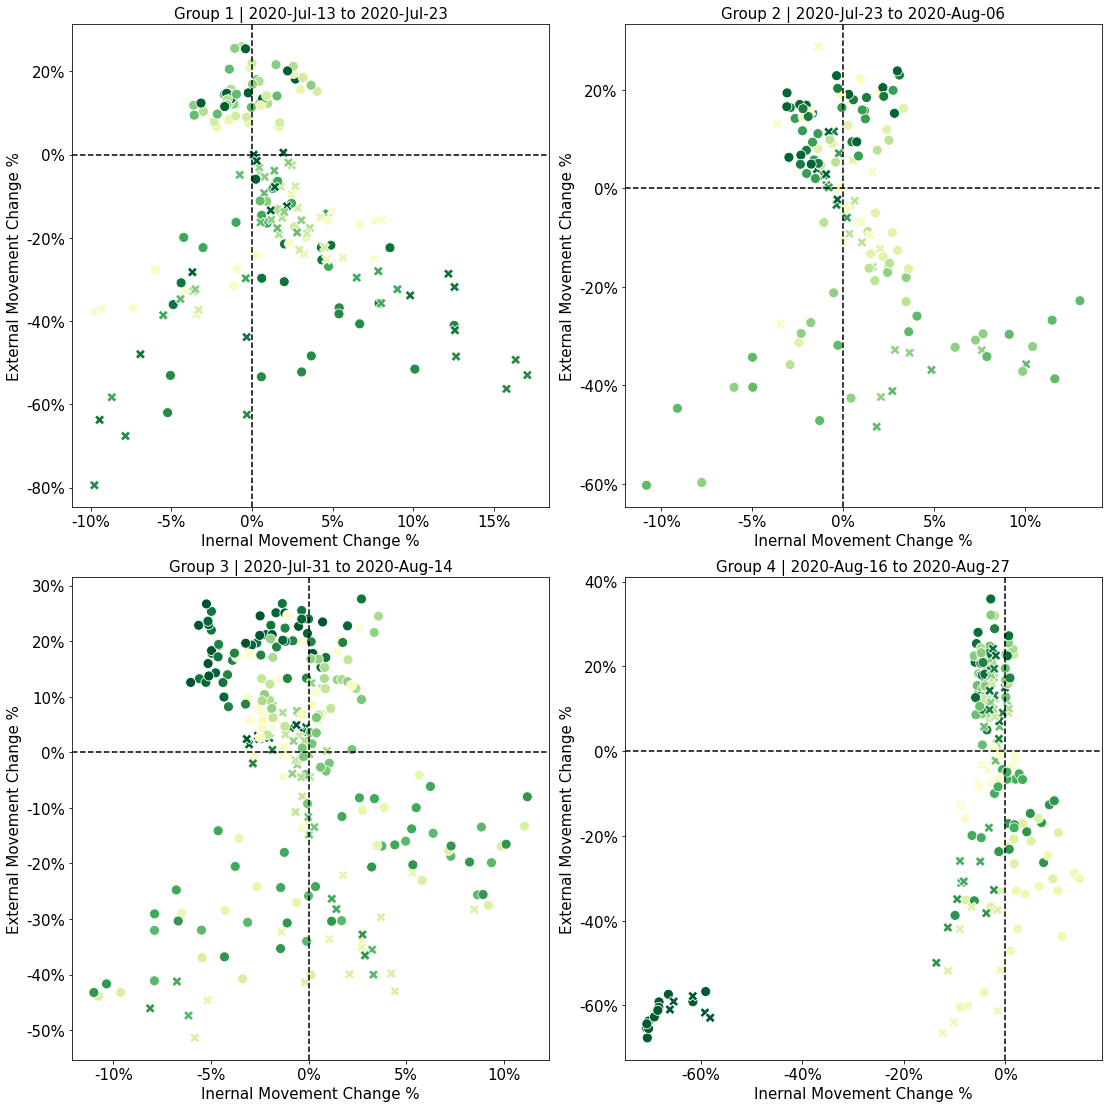

In [7]:
A_merged_df =  all_data_merged[all_data_merged.lockdown_group== 'A']; A_merged_df = A_merged_df[A_merged_df["external"]>-0.95]
B_merged_df =  all_data_merged[all_data_merged.lockdown_group== 'B']; B_merged_df = B_merged_df[B_merged_df["external"]>-0.95]
C_merged_df =  all_data_merged[all_data_merged.lockdown_group== 'C']; C_merged_df = C_merged_df[C_merged_df["external"]>-0.95]
D_merged_df =  all_data_merged[all_data_merged.lockdown_group== 'D']; D_merged_df = D_merged_df[D_merged_df["external"]>-0.95]


################ EXTERNAL ################
fig, ax = plt.subplots(2, 2, figsize=(15.5, 15.5), sharex=False)
sns.scatterplot(ax=ax[0,0], data=A_merged_df, x="internal", y="external", hue="date", style="locked_down", s=100, palette="YlGn")
sns.scatterplot(ax=ax[0,1], data=B_merged_df, x="internal", y="external", hue="date", style="locked_down", s=100, palette="YlGn")
sns.scatterplot(ax=ax[1,0], data=C_merged_df, x="internal", y="external", hue="date", style="locked_down", s=100, palette="YlGn")
sns.scatterplot(ax=ax[1,1], data=D_merged_df, x="internal", y="external", hue="date", style="locked_down", s=100, palette="YlGn")

codes_names = ['Group 1', 'Group 2', 'Group 3', 'Group 4']
for idx, axi in enumerate(ax.flatten()):
    lock = lockdowns[idx]
    axi.axhline(y=0, color='black', linestyle='--')
    axi.axvline(x=0, color='black', linestyle='--')
    axi.legend(loc='upper right', fontsize=15, title='Intervention', title_fontsize=15)
    axi.set_xlabel('Inernal Movement Change %', fontsize=15)
    axi.set_ylabel('External Movement Change %', fontsize=15)
    axi.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0%}"))
    axi.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0%}"))
    axi.tick_params(axis='both', labelsize=15)
    axi.legend().remove()
    axi.set_title(f"{codes_names[idx]} | {lock['start_date'].strftime('%Y-%b-%d')} to {lock['end_date'].strftime('%Y-%b-%d')}", fontsize=15)

plt.tight_layout()
fig.savefig(os.path.join(results_dir, 'figures', 'internal_external_scatter_bayesian_regression.png'), dpi=300,  bbox_inches='tight', transparent=True)
fig.savefig(os.path.join(results_dir, 'figures_paper', 'Fig1.png'), dpi=300,  bbox_inches='tight', transparent=True)


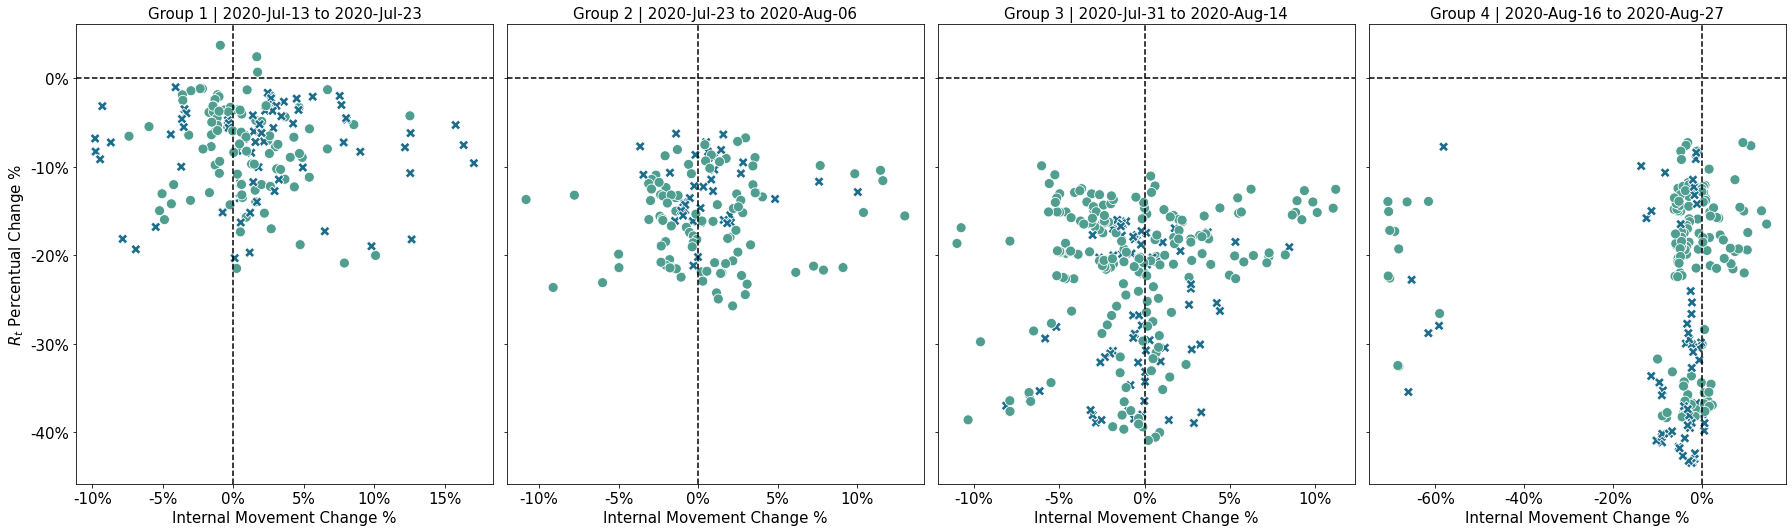

In [8]:

fig, ax = plt.subplots(1, 4, figsize=(25, 7.5), sharey=True)

sns.scatterplot(ax=ax[0], data=A_merged_df, x="internal", y="rt_percentage", hue="locked_down", palette="crest", style="locked_down", s=100)
sns.scatterplot(ax=ax[1], data=B_merged_df, x="internal", y="rt_percentage", hue="locked_down", palette="crest", style="locked_down", s=100)
sns.scatterplot(ax=ax[2], data=C_merged_df, x="internal", y="rt_percentage", hue="locked_down", palette="crest", style="locked_down", s=100)
sns.scatterplot(ax=ax[3], data=D_merged_df, x="internal", y="rt_percentage", hue="locked_down", palette="crest", style="locked_down", s=100)

for idx, axi in enumerate(ax.flatten()):
    lock = lockdowns[idx]

    axi.set_title(f"{codes_names[idx]} | {lock['start_date'].strftime('%Y-%b-%d')} to {lock['end_date'].strftime('%Y-%b-%d')}", fontsize=15)
    axi.legend(loc='upper right', fontsize=15, title='Intervention', title_fontsize=15)
    axi.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0%}"))
    axi.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0%}"))
    axi.set_xlabel('Internal Movement Change %', fontsize=15)
    axi.set_ylabel(r'$R_t$ Percentual Change %', fontsize=15)
    axi.axhline(y=0, color='black', linestyle='--')
    axi.axvline(x=0, color='black', linestyle='--')
    axi.tick_params(axis='both', labelsize=15)
    axi.get_legend().remove()


plt.tight_layout()
fig.savefig(os.path.join(results_dir, 'figures_paper', 'Fig3_A.png'), dpi=300,  bbox_inches='tight', transparent=True)


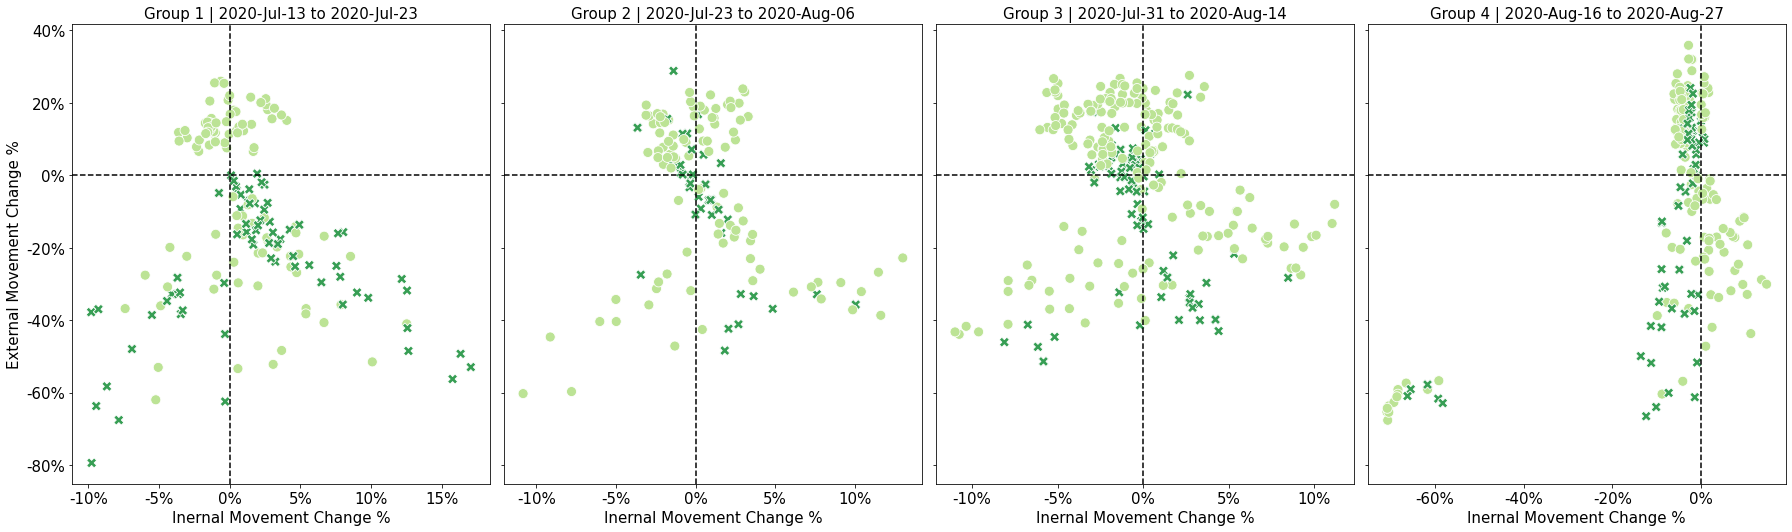

In [9]:
A_merged_df =  all_data_merged[all_data_merged.lockdown_group== 'A']; A_merged_df = A_merged_df[A_merged_df["external"]>-0.95]
B_merged_df =  all_data_merged[all_data_merged.lockdown_group== 'B']; B_merged_df = B_merged_df[B_merged_df["external"]>-0.95]
C_merged_df =  all_data_merged[all_data_merged.lockdown_group== 'C']; C_merged_df = C_merged_df[C_merged_df["external"]>-0.95]
D_merged_df =  all_data_merged[all_data_merged.lockdown_group== 'D']; D_merged_df = D_merged_df[D_merged_df["external"]>-0.95]


################ EXTERNAL ################
fig, ax = plt.subplots(1, 4, figsize=(25, 7.5), sharey=True)
sns.scatterplot(ax=ax[0], data=A_merged_df, x="internal", y="external", hue="locked_down", style="locked_down", s=100, palette="YlGn")
sns.scatterplot(ax=ax[1], data=B_merged_df, x="internal", y="external", hue="locked_down", style="locked_down", s=100, palette="YlGn")
sns.scatterplot(ax=ax[2], data=C_merged_df, x="internal", y="external", hue="locked_down", style="locked_down", s=100, palette="YlGn")
sns.scatterplot(ax=ax[3], data=D_merged_df, x="internal", y="external", hue="locked_down", style="locked_down", s=100, palette="YlGn")

codes_names = ['Group 1', 'Group 2', 'Group 3', 'Group 4']
for idx, axi in enumerate(ax.flatten()):
    lock = lockdowns[idx]
    axi.axhline(y=0, color='black', linestyle='--')
    axi.axvline(x=0, color='black', linestyle='--')
    axi.legend(loc='upper right', fontsize=15, title='Intervention', title_fontsize=15)
    axi.set_xlabel('Inernal Movement Change %', fontsize=15)
    axi.set_ylabel('External Movement Change %', fontsize=15)
    axi.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0%}"))
    axi.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0%}"))
    axi.tick_params(axis='both', labelsize=15)
    axi.legend().remove()
    axi.set_title(f"{codes_names[idx]} | {lock['start_date'].strftime('%Y-%b-%d')} to {lock['end_date'].strftime('%Y-%b-%d')}", fontsize=15)

plt.tight_layout()
fig.savefig(os.path.join(results_dir, 'figures_paper', 'Fig1.png'), dpi=300,  bbox_inches='tight', transparent=True)
